In [1]:
"""
updated 2019-08-06 
written by Minhae Kwon
Linear regression for "Encoding" Process
This code works very well!

ref: https://chrisalbon.com/machine_learning/linear_regression/linear_regression_using_scikit-learn/
     https://datatofish.com/multiple-linear-regression-python/

cross validate score: Coefficient of determination
https://en.wikipedia.org/wiki/Coefficient_of_determination
"""

from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
#from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# hyperparameters
TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 10 # "K" in K-fold cross validation 

In [2]:
# read data
bb_df = read_csv('./data/bb_df.csv') #behavior belief =[belief for box1, beleif for box2]
r_df = read_csv('./data/r_df.csv') # 300 neuron response

### there are 3 types of data: test data, train data, validation data

In [3]:
# separate test data set
r_df_train, r_df_test, bb_df_train, bb_df_test = train_test_split(r_df, bb_df, test_size=TEST_SIZE, random_state = 1)

In [4]:
# linear regression is used for encoding process
regr = LinearRegression(n_jobs = -1) # n_jobs = -1: parallelize taks to use all cpu cores in your machine

In [5]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
X = r_df_train.to_numpy()
y = bb_df_train.to_numpy()
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [6]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X, y.argmax(1))):
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    regr.fit(x_train_kf, y_train_kf) # fit the model
    nb_val = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, nb_val, multioutput='raw_values')) # get r^2 score

score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]
score [1. 1.]


### Linear regression model: B = W * r + c 

In [7]:
"""
c = Intercept
B (behavior belief) N x 2 dimension (N: # of data)
W (Coef): 2 x 300 dimension
r(neural response - 300 neurons) N x 300 dimension
"""

print('Intercept: ', regr.intercept_)
print('Coef: ', regr.coef_)


Intercept:  [0.08159064 0.14304911]
Coef:  [[ 5.85800195e-03  9.35839215e-03 -1.59702473e-02  4.51308006e-02
  -4.63073439e-02 -3.47645620e-03  1.24541666e-02  6.33006724e-02
  -9.39338266e-04  2.08965339e-02  1.57204478e-03 -4.11398487e-02
   1.09673460e-02 -1.34580738e-02 -2.42116669e-02 -3.45607243e-02
  -4.85230732e-02  2.24570353e-02 -4.53351651e-02 -1.64634420e-02
   6.74018733e-02  2.22742258e-02  3.33780736e-02  1.50869316e-02
  -2.91419261e-02  1.25681429e-03  4.43079080e-02  3.22126077e-02
  -4.24613441e-02 -1.54733791e-02 -2.27100900e-02 -4.67519694e-02
   1.87230712e-02  2.88124550e-02  2.31528205e-02  1.20701441e-03
  -2.26490616e-02  1.96624058e-02  5.60522286e-02 -2.12998220e-02
   1.86211432e-02  2.71459369e-02  4.93019048e-02 -2.99019221e-02
  -3.00769998e-02 -2.43045497e-03 -7.98703115e-04 -3.38791468e-02
   1.56938161e-02  1.65410320e-02 -3.46245354e-02 -3.98487391e-02
   1.40451891e-02  2.52954410e-02  1.12389268e-02 -3.77528906e-02
   4.14221844e-03 -2.15916190e-01

### evaluate model with test data

In [8]:
nb_test = regr.predict(r_df_test)

encoding_error = bb_df_test - nb_test # true - estimate
print('encoding mean squared error: \n', np.mean(encoding_error**2, axis=0))
print('encoding error std:\n', np.std(encoding_error, axis=0))
print('score', r2_score(bb_df_test, nb_test, multioutput='raw_values'))

encoding mean squared error: 
 behavior_belief1    9.554392e-13
behavior_belief2    1.396729e-12
dtype: float64
encoding error std:
 behavior_belief1    9.770811e-07
behavior_belief2    1.181502e-06
dtype: float64
score [1. 1.]


In [9]:
nb_df_test = DataFrame(nb_test, columns = bb_df.columns) 

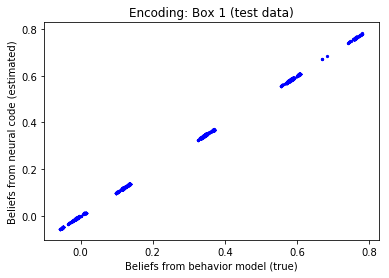

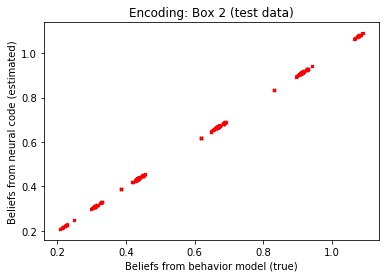

In [10]:

# plot: compare raw data vs prediction
S = 5 # dot size for scatter plot
plt.scatter(bb_df_test['behavior_belief1'], nb_df_test['behavior_belief1'], s=S, c='blue', marker='o')
plt.xlabel('Beliefs from behavior model (true)')
plt.ylabel('Beliefs from neural code (estimated)')
plt.title('Encoding: Box 1 (test data)')
plt.show()

plt.scatter(bb_df_test['behavior_belief2'], nb_df_test['behavior_belief2'], s=S, c='red', marker='x')
plt.xlabel('Beliefs from behavior model (true)')
plt.ylabel('Beliefs from neural code (estimated)')
plt.title('Encoding: Box 2 (test data)')
plt.show()

### build neural belief data using the learned model

In [11]:
#neural estimate of belief using current linear regression model
nb= regr.predict(r_df)  # input is ALL data
nb_df = DataFrame(nb, columns = bb_df.columns)
#save neural estimate belief
nb_df.to_csv(path_or_buf='./data/nb_df.csv',index=False)

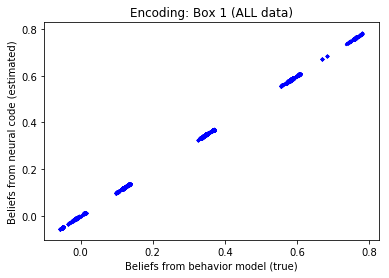

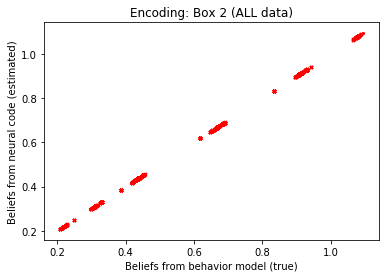

In [12]:
# plot: compare raw data vs prediction
S = 5 # dot size for scatter plot
plt.scatter(bb_df['behavior_belief1'], nb_df['behavior_belief1'], s=S, c='blue', marker='o')
plt.xlabel('Beliefs from behavior model (true)')
plt.ylabel('Beliefs from neural code (estimated)')
plt.title('Encoding: Box 1 (ALL data)')
plt.show()

plt.scatter(bb_df['behavior_belief2'], nb_df['behavior_belief2'], s=S, c='red', marker='x')
plt.xlabel('Beliefs from behavior model (true)')
plt.ylabel('Beliefs from neural code (estimated)')
plt.title('Encoding: Box 2 (ALL data)')
plt.show()
